In [1]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import optax

import hugegp as hg

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

key = jr.key(137)

In [2]:
def register_usage(k, d):
    return d + k*d + 2*k + (k * (k + 1)) // 2

register_usage(17, 3)

241

In [3]:
def default_setup(rng_key):
    n_points = 100
    points = jr.normal(rng_key, (n_points, 2))
    graph = hg.build_kd_graph(points, k=4, start_level=3)
    covariance = hg.test_cov_discretized(0.001, 20, 1000, cutoff=0.2, slope=-1.0, scale=1.0)
    return n_points, graph, covariance

# Test JVP and VJP

In [4]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]

# Define the covariance
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

In [5]:
# Random excitations
key, k1 = jr.split(key)
xi = jr.normal(k1, (2, n_points))

t1 = time.time()
values = hg.generate_refine(graph, covariance, xi[0], cuda=False).block_until_ready()
t2 = time.time()
values_cuda = hg.generate_refine(graph, covariance, xi[0], cuda=True).block_until_ready()
t3 = time.time()
print(f"Cuda time: {1000*(t3 - t2):.2f} ms")
print(f"Jax time: {1000*(t2 - t1):.2f} ms")

Cuda time: 28.57 ms
Jax time: 3584.38 ms


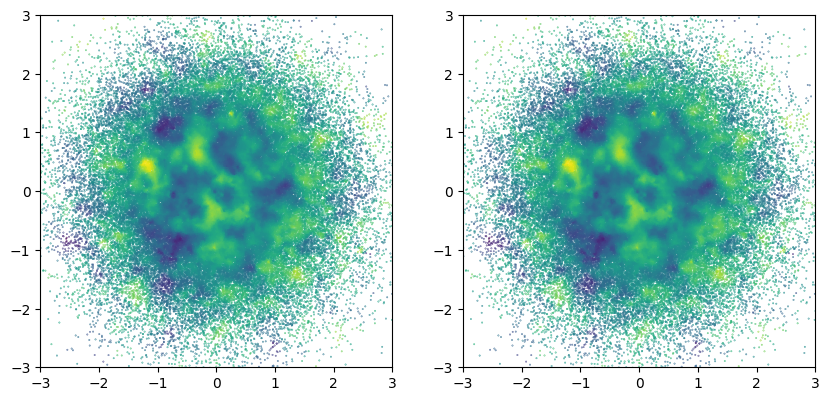

In [6]:
# Plot
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values, s=0.1, cmap='viridis')
axes[1].scatter(*points.T, c=values_cuda, s=0.1, cmap='viridis')
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()

In [ ]:
func = Partial(hg.generate_refine, graph, covariance, cuda=False)
func_cuda = Partial(hg.generate_refine, graph, covariance, cuda=True)

func = jax.vmap(func)
func_cuda = jax.vmap(func_cuda)

In [ ]:
_, dv = jax.jvp(func, (xi,), (jnp.ones_like(xi),))
dv[:,1023:]

In [ ]:
_, dv_cuda = jax.jvp(func_cuda, (xi,), (jnp.ones_like(xi),))
dv_cuda[:,1023:]

In [ ]:
primals_out, vjp_func = jax.vjp(func, xi)
vjp_eval = vjp_func(jnp.ones_like(xi))
vjp_eval[0][:,1023:]

In [ ]:
primals_out, vjp_func = jax.vjp(func_cuda, xi)
vjp_eval_cuda = vjp_func(jnp.ones_like(xi))
vjp_eval_cuda[0][:,1023:]

In [ ]:
plt.plot(vjp_eval[0][1023:1200:], lw=1)
plt.plot(vjp_eval_cuda[0][1023:1200], lw=1, ls='--')
plt.gca().set(xlabel='random parameter', ylabel='vjp')
plt.show()

In [ ]:
plt.scatter(vjp_eval[0], vjp_eval_cuda[0], s=0.1)
plt.gca().set(aspect='equal', xscale='log', yscale='log', xlabel='jax vjp', ylabel='cuda vjp', title='order 2')
plt.show()

# Test Hessian

In [ ]:
key, k1, k2 = jr.split(key, 3)
n_points, graph, covariance = default_setup(k1)
xi = jr.normal(k2, (n_points,)) 

In [ ]:
def loss_func(xi, cuda=False):
    return jnp.sum(jnp.square(hg.generate_refine(graph, covariance, xi, cuda=cuda)))

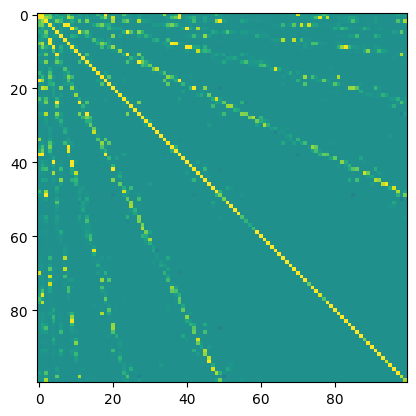

In [ ]:
plt.imshow(jax.hessian(Partial(loss_func, cuda=False))(xi), vmin=-1, vmax=1)

(100,) (7,)
(1, 100) (1, 7)
(1, 100) (1, 7)
(1, 100) (1, 7)
(100, 1, 100) (100, 1, 7)


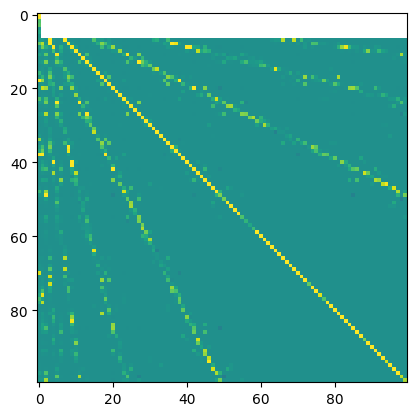

In [ ]:
plt.imshow(jax.hessian(Partial(loss_func, cuda=True))(xi), vmin=-1, vmax=1)

# Test gradient optimization


In [ ]:
# Generate points
n_points = 1_000_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=10)
points = graph[0]
n_initial = int(graph[1][0])

# Define the covariance
covariance = hg.covariance.test_cov_sampled()

# Generate truth
key, k1 = jr.split(key)
xi_true = jr.normal(k1, (n_points,))
values_true = hg.generate_refine(graph, covariance, xi_true, cuda=True).block_until_ready()
values_true

In [ ]:
# Set up optimization
optimizer = optax.adam(0.03)
key, k1 = jr.split(key)
xi_guess = jr.normal(k1, (n_points,))

def loss_fn(xi):
    values = hg.generate_refine(graph, covariance, xi, cuda=True)
    return jnp.sum(jnp.square(values - values_true))

# # Optimization step
@jax.jit
def step(carry):
    xi, optimizer_state = carry
    loss, grad = jax.value_and_grad(loss_fn)(xi)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    xi = optax.apply_updates(xi, updates)
    return (xi, optimizer_state), loss

In [ ]:
# Optimize!
xi = xi_guess
optimizer_state = optimizer.init(xi_guess)
loss_hist = []
values_hist = []

for i in tqdm(range(1000)):
    (xi, optimizer_state), loss = step((xi, optimizer_state))
    loss_hist.append(float(loss))
    # values_hist.append(hg.generate_refine(graph, covariance, xi, cuda=True))

values = hg.generate_refine(graph, covariance, xi, cuda=True).block_until_ready()

plt.plot(loss_hist, lw=1)
plt.show()

In [ ]:
# Animate optimization
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values_true, s=1, cmap='viridis', vmin=-3, vmax=3)
s = axes[1].scatter(*points.T, c=values_hist[0], s=1, cmap='viridis', vmin=-3, vmax=3)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

def update(i):
    s.set_array(values_hist[i])
    return s,

ani = FuncAnimation(fig, update, frames=jnp.arange(0, len(values_hist), 10), blit=True, interval=1000/10)
plt.close()
HTML(ani.to_html5_video())

In [ ]:
plt.scatter(values_true, values)

In [ ]:
plt.scatter(xi_true, xi, s=1)

# Test kernel derivatives

In [ ]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=5)
points = graph[0]
n_initial = int(graph[1][0])

# Generate some fixed xi
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))

# Define forward model
def forward(cov_params):
    cutoff, slope, scale = cov_params
    covariance = hg.covariance.test_cov_sampled(cutoff=cutoff, slope=slope, scale=scale)
    return hg.generate_refine(graph, covariance, xi, cuda=False)

# Generate true values
cov_params_true = jnp.array([0.2, -1.0, 1.0])
values_true = forward(cov_params_true)

In [ ]:
jax.jvp(forward, (cov_params_true,), (jnp.ones_like(cov_params_true),))

In [ ]:
jax.vjp(forward, cov_params_true)[1](jnp.ones_like(forward(cov_params_true)))

In [ ]:
cov_params_guess = jnp.array([0.8, -4.0, 0.3])
plt.scatter(*points.T, c=forward(cov_params_guess), s=1, cmap='viridis', vmin=-3, vmax=3)

In [ ]:
# Set up optimization
optimizer = optax.adam(0.03)
key, k1 = jr.split(key)
cov_params_guess = jnp.array([0.4, -3.0, 0.3])

def loss_fn(cov_params):
    values = forward(cov_params)
    return jnp.sum(jnp.square(values - values_true))

# # Optimization step
@jax.jit
def step(carry):
    cov_params, optimizer_state = carry
    loss, grad = jax.value_and_grad(loss_fn)(cov_params)
    updates, optimizer_state = optimizer.update(grad, optimizer_state)
    cov_params = optax.apply_updates(cov_params, updates)
    return (cov_params, optimizer_state), loss

In [ ]:
# Optimize!
cov_params = cov_params_guess
optimizer_state = optimizer.init(cov_params)
loss_hist = []
values_hist = []

for i in tqdm(range(100)):
    (cov_params, optimizer_state), loss = step((cov_params, optimizer_state))
    loss_hist.append(float(loss))
    values_hist.append(forward(cov_params))

values = forward(cov_params)

plt.plot(loss_hist, lw=1)
plt.show()

In [ ]:
# Animate optimization
fig, axes = plt.subplots(ncols=2, figsize=(10, 5))
axes[0].scatter(*points.T, c=values_true, s=1, cmap='viridis', vmin=-3, vmax=3)
s = axes[1].scatter(*points.T, c=values_hist[0], s=1, cmap='viridis', vmin=-3, vmax=3)
for ax in axes:
    ax.set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))

def update(i):
    s.set_array(values_hist[i])
    return s,

ani = FuncAnimation(fig, update, frames=jnp.arange(0, len(values_hist), 10), blit=True, interval=1000/1)
plt.close()
HTML(ani.to_jshtml())

# Test manual AD of sqrt term

In [ ]:
fine_point = jnp.array([0.0, 0.0])
coarse_point = jnp.array([0.0, 1e-9])
r = jnp.linalg.norm(fine_point - coarse_point)


def cov_func(r, scale):
    result = scale * (1 + (r / 0.2) ** 2) ** (-1)
    result = jnp.where(r == 0.0, result * (1 + 1e-4), result)
    return result

def func(scale):
    Kff = cov_func(0.0, scale)
    Kfc = cov_func(r, scale)
    Kcc = cov_func(0.0, scale)
    return jnp.sqrt(Kff - Kfc**2 / Kcc)

def func_grad(scale):
    Kff = cov_func(0.0, scale)
    Kfc = cov_func(r, scale)
    Kcc = cov_func(0.0, scale)
    dKff = jax.grad(cov_func, argnums=1)(0.0, scale)
    dKfc = jax.grad(cov_func, argnums=1)(r, scale)
    dKcc = jax.grad(cov_func, argnums=1)(0.0, scale)
    return (dKff - 2*Kfc*dKfc/Kcc + Kfc**2/Kcc**2 * dKcc) / (2 * jnp.sqrt(Kff - Kfc**2 / Kcc))

print(func(1.0))
print(func_grad(1.0))
print(jax.grad(func)(1.0))

# Test per-pixel variance

In [25]:
# Generate points
n_points = 100_000
key, k1 = jr.split(key)
points = jr.normal(k1, (n_points, 2))

# Compute neighbors
graph = hg.build_kd_graph(points, k=4, start_level=4)
points = graph[0]

# Define the covariance
covariance = hg.test_cov_discretized(1e-3, 20, 1000)

In [ ]:
# Generate many random realizations
n_trials = 100
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_trials, n_points))
values = jax.vmap(Partial(hg.generate_refine, graph, covariance, cuda=True))(xi)
variance_per_point = jnp.var(values, axis=0)

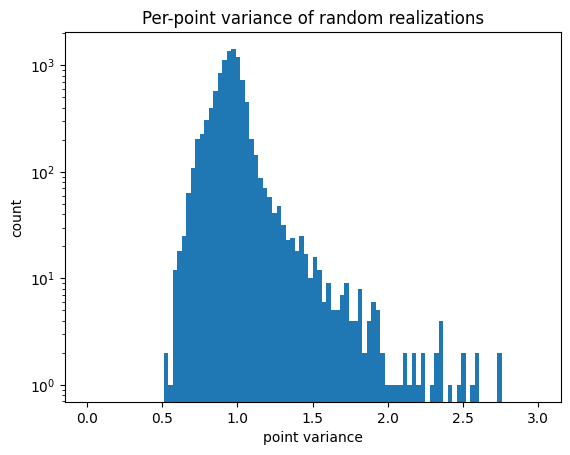

In [ ]:
plt.hist(variance_per_point, bins=100, range=(0, 3))
plt.gca().set(yscale='log', xlabel='point variance', ylabel='count', title='Per-point variance of random realizations')
plt.show()

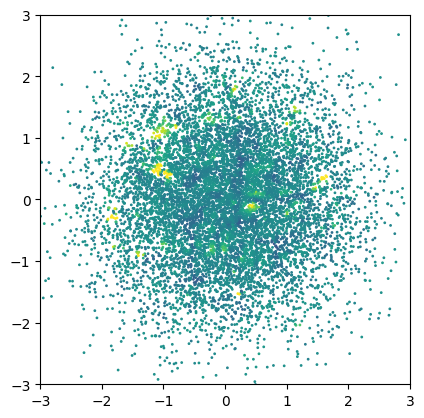

In [23]:
plt.scatter(*points.T, c=variance_per_point, s=1, vmin=0, vmax=2)
plt.gca().set(aspect='equal', xlim=(-3, 3), ylim=(-3, 3))
plt.show()

# Test KL as a function of neighbors

In [10]:
n_dim_scan = [1, 2, 3]
n_points_scan = [1000]
k_scan = [2, 3, 4, 5, 6, 7, 8]
kl_scan = []

covariance = hg.test_cov_discretized(1e-3, 10, 1000)

for n_dim in tqdm(n_dim_scan):
    kl_scan.append([])

    for n_points in n_points_scan:
        kl_scan[-1].append([])

        points_radius = jnp.logspace(-2, 0, n_points)
        key, k1 = jr.split(key)
        points = jr.normal(k1, (n_points, n_dim))
        points /= jnp.linalg.norm(points, axis=-1, keepdims=True)
        points *= points_radius[:, None]

        graph = hg.build_kd_graph(points, k=1, start_level=4)
        points = graph[0]
        exact_func = Partial(hg.generate, points, covariance)
        J_exact = jax.jacfwd(exact_func)(jnp.zeros((n_points,)))
        K_exact = J_exact @ J_exact.T
        
        for k in k_scan:
            graph = hg.build_kd_graph(points, k=k, start_level=4)
            func = Partial(hg.generate_refine, graph, covariance, cuda=True)
            J = jax.jacfwd(func)(jnp.zeros((n_points,)))
            K = J @ J.T

            solved = jnp.linalg.solve(K, K_exact)
            kl = 1 / 2 * (jnp.trace(solved) - jnp.linalg.slogdet(solved)[1] - len(K_exact))
            kl_per_dof = kl / n_points / jnp.log(2)

            kl_scan[-1][-1].append(kl_per_dof)

kl_scan = jnp.array(kl_scan)

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:11<00:00,  3.69s/it]


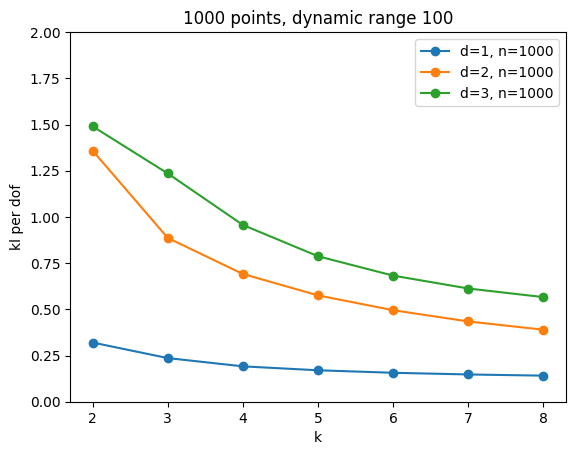

In [51]:
for n_dim in range(len(n_dim_scan)):
    plt.plot(k_scan, kl_scan[n_dim][0], marker='o', c=f'C{n_dim}', label=f'd={n_dim_scan[n_dim]}, n={n_points_scan[0]}')
    plt.legend()
plt.gca().set(ylim=(0,2), xlabel='k', ylabel='kl per dof', title=f'{n_points} points, dynamic range {points_radius[-1]/points_radius[0]:.0f}')
plt.show()

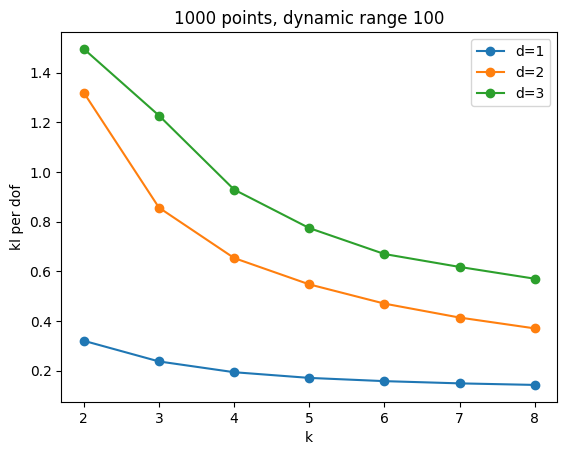

In [163]:
for n_dim in range(len(n_dim_scan)):
    plt.plot(k_scan, kl_scan[n_dim], label=f'd={n_dim_scan[n_dim]}', marker='o')
plt.legend()
plt.gca().set(xlabel='k', ylabel='kl per dof', title=f'{n_points} points, dynamic range {points_radius[-1]/points_radius[0]:.0f}')
plt.show()

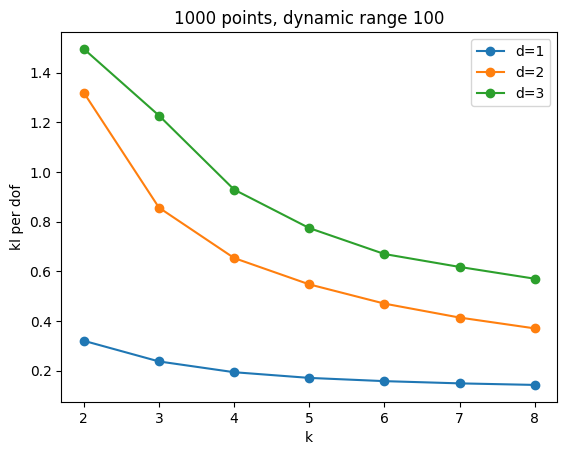

In [165]:
for n_dim in range(len(n_dim_scan)):
    plt.plot(k_scan, kl_scan[n_dim], label=f'd={n_dim_scan[n_dim]}', marker='o')
plt.legend()
plt.gca().set(xlabel='k', ylabel='kl per dof', title=f'{n_points} points, dynamic range {points_radius[-1]/points_radius[0]:.0f}')
plt.show()

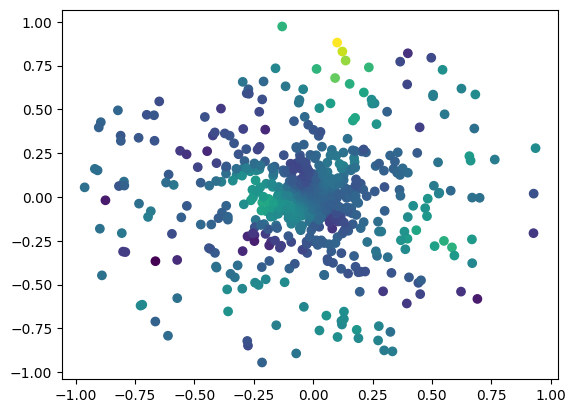

In [139]:
key, k1 = jr.split(key)
xi = jr.normal(k1, (n_points,))
values = func(xi)
plt.scatter(*points.T, c=values)
# plt.scatter(points, values)